In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from pre_post_process import *

_, ratings = load_data("data_train.csv")
sample_ids, _ = load_data("sample_submission.csv")
print(np.shape(ratings))

number of items: 1000, number of users: 10000
number of items: 1000, number of users: 10000
(1000, 10000)


### Plot the number of ratings per movie and user

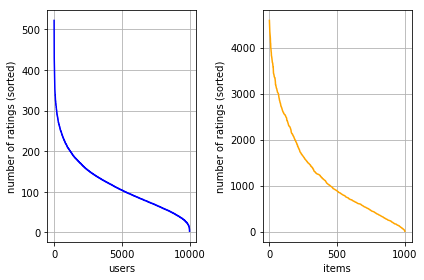

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
valid_ratings, train, test = split_data(ratings, p_test=0.1)

the shape of original ratings. (# of row, # of col): (1000, 10000)
the shape of valid ratings. (# of row, # of col): (1000, 10000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1068598
Total number of nonzero elements in test data:108354


### Finding parameters for SGD

In [5]:
from SGD_helpers import *

We need to find the values of the step size $\gamma$ first for a fixed value of the 3 other parameters and then compute a grid search to find the best parameters for the regularizers $\lambda_{user}$, $\lambda_{item}$ (both between 0 and 1) and the number of features $K$

In [159]:
# Finding gamma:
gammas = np.logspace(-5,0,6) # errors on tests are [4.58, 1.43, 1.05, 1.02, nan, nan] Above 0.05 -> nan
K = 50
lambda_user = 0.01
lambda_item = 0.01
num_epochs = 20
errors = []

for gamma in gammas:
    # Initialize features matrix
    user_init, item_init = init_MF(train, K)
    # Compute SGD
    _, _, rmse = matrix_factorization_SGD(train, test, gamma, K, lambda_user, lambda_item, num_epochs, user_init, item_init)
    errors.append(rmse)

Learn the matrix factorization using SGD with K = 50, lambda_i = 0.01, lambda_u = 0.01
iter: 0, RMSE on training set: 1.0254163402880199.
iter: 5, RMSE on training set: 0.9970562707025038.
iter: 10, RMSE on training set: 0.9878420873516897.
iter: 15, RMSE on training set: 0.9827800385900544.
RMSE on test data: 0.9956946199719938.
Learn the matrix factorization using SGD with K = 50, lambda_i = 0.01, lambda_u = 0.01
iter: 0, RMSE on training set: 1.0476258793239321.
iter: 5, RMSE on training set: 0.9589571948307791.
iter: 10, RMSE on training set: 0.8527435785856862.
iter: 15, RMSE on training set: 0.8095947135380929.
RMSE on test data: 1.0043973015749026.
Learn the matrix factorization using SGD with K = 50, lambda_i = 0.01, lambda_u = 0.01
iter: 0, RMSE on training set: 1.0919266199950395.
iter: 5, RMSE on training set: 0.7711472883038539.
iter: 10, RMSE on training set: 0.6921353233596186.
iter: 15, RMSE on training set: 0.6730727947086461.
RMSE on test data: 1.1173694899753186.


After many computations (not only on logspace) for same parameters for K and the 2 lambdas, we found that $\gamma = 0.025$ is the best

In [ ]:
# Grid Search:
grid = np.zeros((4, 4, 4))
gamma = 0.025 # best gamma we found above
num_epochs = 20
lambdas_user = [0.01, 0.05]#np.logspace(-3,0,4)[::-1] #From max to min
lambdas_item = [0.05, 0.1, 0.5]
num_features = np.linspace(20,100,4)
min_loss = 100000

for x,K in enumerate(num_features):
    ### Warm start: directly start computation from previously computed item_features and user_features and not random initialization 
    user_init, item_init = init_MF(train, int(K))
    for y,lambda_u in enumerate(lambdas_user):
        for z,lambda_i in enumerate(lambdas_item):
            print("K = {}, lambda_u = {}, lambda_i = {}".format(int(K), lambda_u, lambda_i))
            item_feats, user_feats, rmse = matrix_factorization_SGD(train, test, gamma, int(K), lambda_u, lambda_i, num_epochs,
                                                                    user_init, item_init)
            ### For warm start, we keep the user_features and item_features that gave us the minimal rmse previously computed
            if rmse < min_loss:
                min_loss = rmse
                user_init = user_feats
                item_init = item_feats
            grid[x, y, z] = rmse

K = 20, lambda_u = 0.005, lambda_i = 0.05
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.05, lambda_u = 0.005
iter: 0, RMSE on training set: 1.0319645103983506.
iter: 5, RMSE on training set: 1.00386363668872.
iter: 10, RMSE on training set: 0.9852919940605751.
iter: 15, RMSE on training set: 0.9756309207073471.
RMSE on test data: 0.9919069009109023.
K = 20, lambda_u = 0.005, lambda_i = 0.1
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.1, lambda_u = 0.005
iter: 0, RMSE on training set: 1.0155132474468431.
iter: 5, RMSE on training set: 0.9580145579687189.
iter: 10, RMSE on training set: 0.9282677738283455.
iter: 15, RMSE on training set: 0.9178277238362167.
RMSE on test data: 0.9855366773648361.
K = 20, lambda_u = 0.005, lambda_i = 0.5
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.5, lambda_u = 0.005
iter: 0, RMSE on training set: 1.0411236927654304.
iter: 5, RMSE on training set: 0.9932798549544953.
iter: 10, RMSE on traini

In [20]:
'''TEST'''
t = np.matrix([[1.416,, 4],[1, 4,9, 16],[1, 8, 27, 64],[1, 16, 81, 100]])
ax = plt.axes()
cmap = sns.color_palette("Blues")
sns.heatmap(t, ax = ax, cmap = cmap, square = True)
lambdas_test1 = [0.001, 0.01, 0.1, 1.0]
lambdas_test2 = [0.001, 0.01, 0.1, 1.0]
ax.set_xticklabels(lambdas_test1)
ax.set_yticklabels(lambdas_test2)
ax.set_xlabel("Lambda user")
ax.set_ylabel("Lambda item")
plt.title("Grid Search for minimal RMSE depending on regularizers lambda user and lambda item")

SyntaxError: invalid syntax (<ipython-input-20-83ef03b58d55>, line 2)

In [ ]:
grid = np.matrix([[1.1,1.1,1.0836,0.9951],[1.0719, 1.0446, 0.9902, 1.0103],[1.009, 0.9855, 1.0043, 1.050],[1.007, 1.007, 1.048, 1.416]])
ax = plt.axes()
cmap = sns.palplot(sns.light_palette("red", reverse=True))
sns.heatmap(t, ax = ax, cmap = cmap, square = True)
lambdas_test1 = [0.001, 0.01, 0.1, 1.0]
lambdas_test2 = [0.001, 0.01, 0.1, 1.0]
ax.set_xticklabels(lambdas_test1)
ax.set_yticklabels(lambdas_test2)
ax.set_xlabel("Lambda user")
ax.set_ylabel("Lambda item")
plt.title("Grid Search for minimal RMSE depending on regularizers lambda user and lambda item")

Run the SGD with the best parameters we found:

In [8]:
best_gamma = 0.025
best_lambda_u = 0.1
best_lambda_i = 0.01
K = 20
num_epochs = 20

user_init, item_init = init_MF(train, K)

item_feats_SGD, user_feats_SGD, rmse = matrix_factorization_SGD(ratings, test, best_gamma, K, best_lambda_u, best_lambda_i, num_epochs,
                                                                    user_init, item_init, include_test = False)
user_init, item_init = init_MF(train, K)
item_feats2_SGD, user_feats2_SGD, rmse = matrix_factorization_SGD(ratings, test, best_gamma, K, best_lambda_u, best_lambda_i, 100,
                                                                    user_init, item_init, include_test = False)

Learn the matrix factorization using SGD with K = 20, lambda_i = 0.01, lambda_u = 0.1
iter: 0, RMSE on training set: 1.049493431379777.
iter: 5, RMSE on training set: 0.9917019620172697.
iter: 10, RMSE on training set: 0.9462150810318175.
iter: 15, RMSE on training set: 0.9264185722848745.
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.01, lambda_u = 0.1
iter: 0, RMSE on training set: 1.0494871119227165.
iter: 5, RMSE on training set: 0.9906779012935527.
iter: 10, RMSE on training set: 0.9444948358625014.
iter: 15, RMSE on training set: 0.924736391461175.
iter: 20, RMSE on training set: 0.9177705836387646.
iter: 25, RMSE on training set: 0.9152491052507084.
iter: 30, RMSE on training set: 0.9142824072136536.
iter: 35, RMSE on training set: 0.9139015618343987.
iter: 40, RMSE on training set: 0.9137478691018356.
iter: 45, RMSE on training set: 0.9136861943271423.
iter: 50, RMSE on training set: 0.9136614109781991.
iter: 55, RMSE on training set: 0.9136514502341064.
it

In [11]:
predictions = np.dot(item_feats2_SGD.T, user_feats2_SGD)
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))

Shape of predictions (user x items): (1000, 10000)


### Adding biases

In [6]:
from bias_helpers import *

Instead of having $p_{u, i} = \mathbf{w}_i\mathbf{z^{T}}_u$ we would add bias on the user and item by having the following:
$$p_{u, i} = \mu + b_{u} + b_{i} + \mathbf{w}_i\mathbf{z^{T}}_u$$

where $\mu$ is the average of all ratings, $b_{u}$ and $b_{i}$ are the observed deviations of user u and item i respectively from the average (the biases).

Thus we now want to find the best $\mathbf{W}$ and $\mathbf{U}$ that minimizes the loss:

$$min_{W,Z}\ \frac{1}{2} \sum_{(u, i) \in \omega} (r_{u,i} - \mu - b_{u} - b_{i} - \mathbf{W_{u}} \mathbf{Z^{T}_{i}}) + \lambda_{item} (||W||_{F}^{2} + b_{i}^{2}) + \lambda_{user} (||Z||_{F}^{2} + b_{u}^{2}) $$

And we need to compute the gradient of this loss. It is the same as before except we can convert our rating matrix to a biased rating matrix with ratings $r'_{u, i} = r_{u, i} - \mu - b_{u} - b_{i}$ and compute our SGD on this biased matrix

In [13]:
bias_train, mean, bias_u_train, bias_i_train = computeBiasMatrix(train) #ratings for final submissions
bias_test, _, _, _ = computeBiasMatrix(test)

C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\bias_helpers.py:24: RuntimeWarning: invalid value encountered in true_divide
  mean_users = [mean_users[0, i] for i in range(num_users)]/nz_users
C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\bias_helpers.py:26: RuntimeWarning: invalid value encountered in true_divide
  mean_items = [mean_items[i, 0] for i in range(num_items)]/nz_items


In [19]:
# Grid Search:
grid = np.zeros((4, 4)) ### np.zeros((4, 4, 4))
gamma = 0.025 # best gamma we found above
num_epochs = 20
lambdas_user = np.logspace(-3,0,4)[::-1] #From max to min
lambdas_item = np.logspace(-3,0,4)[::-1]
#num_features = np.linspace(20,100,4)
K = 20
min_loss = 100000

### Warm start: directly start computation from previously computed item_features and user_features and not random initialization 
user_init, item_init = init_MF(train, K)
for x,lambda_u in enumerate(lambdas_user):
    for y,lambda_i in enumerate(lambdas_item):
        print("K = {}, lambda_u = {}, lambda_i = {}".format(int(K), lambda_u, lambda_i))
        item_feats, user_feats, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_u,
                                                                lambda_i, num_epochs, user_init, item_init)
        ### For warm start, we keep the user_features and item_features that gave us the minimal rmse previously computed
        if rmse < min_loss:
            print("Entered")
            min_loss = rmse
            user_init = user_feats
            item_init = item_feats
        grid[x, y] = rmse

K = 20, lambda_u = 1.0, lambda_i = 1.0
Learn the matrix factorization using SGD with K = 20, lambda_i = 1.0, lambda_u = 1.0
iter: 0, RMSE on training set: 0.9950116460840475.
iter: 5, RMSE on training set: 0.9950141371196208.
iter: 10, RMSE on training set: 0.9950141496724862.
iter: 15, RMSE on training set: 0.9950141514276349.
RMSE on test data: 0.9584170940125771.
Entered
K = 20, lambda_u = 1.0, lambda_i = 0.1
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.1, lambda_u = 1.0
iter: 0, RMSE on training set: 0.9950141420014696.
iter: 5, RMSE on training set: 0.9950141520396367.
iter: 10, RMSE on training set: 0.9950141530242792.
iter: 15, RMSE on training set: 0.995014153266552.
RMSE on test data: 0.9584170952714977.
K = 20, lambda_u = 1.0, lambda_i = 0.01
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.01, lambda_u = 1.0
iter: 0, RMSE on training set: 0.9950141512207128.
iter: 5, RMSE on training set: 0.9950141258529559.
iter: 10, RMSE on training 

C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\SGD_helpers.py:53: RuntimeWarning: overflow encountered in multiply
  user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\SGD_helpers.py:52: RuntimeWarning: overflow encountered in multiply
  item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\SGD_helpers.py:53: RuntimeWarning: invalid value encountered in subtract
  user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\SGD_helpers.py:52: RuntimeWarning: invalid value encountered in add
  item_features[:, d] += gamma * (err * user_info - lambda_item * it

iter: 5, RMSE on training set: nan.
iter: 10, RMSE on training set: nan.
iter: 15, RMSE on training set: nan.
RMSE on test data: nan.
K = 20, lambda_u = 0.001, lambda_i = 0.001
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.001, lambda_u = 0.001
iter: 0, RMSE on training set: nan.
iter: 5, RMSE on training set: nan.
iter: 10, RMSE on training set: nan.
iter: 15, RMSE on training set: nan.
RMSE on test data: nan.


In [ ]:
print(min_loss)

In [18]:
# define parameters
gamma = 0.025
K = 20
lambda_user = 0.001
lambda_item = 1.0
num_epochs = 20
user_init, item_init = init_MF(bias_train, K)

item_featuresSGD, user_featuresSGD, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_user,
                                                              lambda_item, num_epochs, user_init, item_init, include_test = False)


Learn the matrix factorization using SGD with K = 20, lambda_i = 1.0, lambda_u = 0.001
iter: 0, RMSE on training set: 0.9950023491148128.
iter: 5, RMSE on training set: 0.9949891307219013.
iter: 10, RMSE on training set: 0.9949801034480176.
iter: 15, RMSE on training set: 0.9949762003882027.


In [15]:
# Compute predictions matrix from the biases, item and user features computed with SGD
predictions = predictionsWithBias(item_featuresSGD, user_featuresSGD, bias_u_train, bias_i_train, mean)
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))

(1000, 10000)
Shape of predictions (user x items): (1000, 10000)


In [16]:
### Checking if results appear the same in the final excel file
first_user, first_item = sample_ids[0][0],sample_ids[0][1]
print(first_item, first_user)
print(predictions[0, 36])

1 37
3.3532282857


### Submission

In [17]:
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))
wanted_preds = getWantedPredictions(predictions.T, sample_ids)
create_csv_submission(sample_ids, wanted_preds, "submissions/SGD_bias_train.csv")

Shape of predictions (user x items): (1000, 10000)
